# Function 2: 2D Mystery ML Model

*Analogy: Tuning a simple machine learning model to maximize its log-likelihood score.*

### Characteristics

* Noisy: "Each output is noisy." The observed $y$ varies ($y + \epsilon$). Querying $(x_1, x_2)$ twice yields different results.

* Landscape: "Complex functions with many local peaks." There is a high risk of getting stuck in a local optimum.

* Strategy: Requires balancing exploration (checking new areas) vs exploitation (refining known good spots) to handle noise.

## 1. Setup and load data (read-only from initial_data)

In [1]:
# ==== External libraries ====
import sys
import copy
import numpy as np
from mpl_toolkits.mplot3d import Axes3D  # registers the 3D projection
from pathlib import Path
from scipy.stats import norm
import matplotlib.pyplot as plt
from matplotlib import cm
plt.style.use("seaborn-v0_8")

# ==== Project path + internal utilities ====
repo_root = Path.cwd() if (Path.cwd() / "src").exists() else Path.cwd().parent
sys.path.insert(0, str(repo_root))
from src.utils.load_challenge_data import (
    load_function_data,
    load_problem_data_csv,
    assert_not_under_initial_data,
)
from src.utils.sampling_utils import sample_candidates

np.random.seed(42)


In [2]:
# Load: under data/ we use only CSV. observations.csv if present, else initial_data (read-only).
local_dir = repo_root / "data" / "problems" / "function_2"
csv_path = local_dir / "observations.csv"
PLOT_EXPORT_DIR = repo_root / "data" / "results"
print('Set data directory to', local_dir)

Set data directory to /Users/nikolaskarefyllidis/Desktop/60_ML-AI/10 main optimization/10 ICL BBO Challenge/black-box-optimization/data/problems/function_2


In [3]:
# Run-time flags — toggle without re-running the whole notebook
IF_SHOW_PLOT      = True   # call plt.show() after each figure
IF_EXPORT_PLOT    = False  # save figures to PLOT_EXPORT_DIR
IF_EXPORT_QUERIES = True   # write next_x to data/submissions/
IF_APPEND_DATA    = False  # append new observation to observations.csv
print('Control flags set')


Control flags set


In [4]:
# ==== Probabilistic surrogate models (sklearn) ====
# GaussianProcessRegressor: fits GP to (X, y); predict() returns posterior μ and σ.
from sklearn.gaussian_process import GaussianProcessRegressor
# Kernels define the GP covariance (smoothness / structure of the objective):
#   RBF              — infinitely smooth, isotropic.
#   Matern           — rougher than RBF; ν=1.5 → once differentiable.
#   ConstantKernel   — output-scale prefactor.
#   WhiteKernel      — explicit i.i.d. observation noise.
#   DotProduct       — linear (inner-product) kernel.
#   RationalQuadratic — scale mixture of RBFs; multi-length-scale.
#   ExpSineSquared   — periodic / cyclic patterns.
#   PairwiseKernel   — wraps any sklearn pairwise metric as a kernel.
from sklearn.gaussian_process.kernels import (
    RBF, Matern, ConstantKernel, WhiteKernel,
    DotProduct, RationalQuadratic, ExpSineSquared, PairwiseKernel,
)

# ==== Acquisition functions (skopt) ====
# skopt assumes minimization — we fit aux GPs on −y so argmax acq ≡ argmax y.
#   gaussian_ei  — E[max(f(x)−f(x⁺), 0)]; ξ trades off exploitation vs exploration.
#   gaussian_pi  — P(f(x) > f(x⁺)+ξ); greedier than EI.
#   gaussian_lcb — μ(x) − κσ(x); minimize LCB of −y ≡ maximize UCB of y.
from skopt.acquisition import gaussian_ei, gaussian_pi, gaussian_lcb

# ==== Candidate samplers (skopt) ====
# Generate the pool of points over which the acquisition function is maximized.
#   Lhs   — Latin Hypercube: stratified, good uniform coverage.
#   Sobol — quasi-random low-discrepancy sequence; better than random for d ≥ 2.
from skopt.sampler import Lhs, Sobol


In [5]:
# ==== GP kernel hyperparameters ====
CONSTANT_KERNEL_SCALE = 1.0    # output-scale; normalized y so value matters little
LENGTH_SCALE          = 0.20   # init length-scale; sklearn optimizes this — lower = wigglier
GP_ALPHA              = 1e-6   # nugget for numerical stability; raise to 1e-4 if Cholesky fails
MATERN_NU             = 1.5    # roughness: 0.5=exp, 1.5=C¹, 2.5=C², ∞=RBF
WHITE_NOISE_LEVEL     = 1e-2   # F2 is noisy: higher so GP doesn't overtrust observations

# ==== Acquisition coefficients ====
# F2 noisy / multi-peak — favour exploration.
XI_EI_PI  = 0.15   # ξ for EI/PI: higher = more exploration
KAPPA_UCB = 4.0    # κ for UCB: higher = more exploration

# ==== Candidate sampling ====
n_grid = 100   # 2D grid resolution (for plotting)
n_cand = n_grid * n_grid
CANDIDATE_SAMPLING_METHOD = "sobol"  # 'grid' | 'lhs' | 'sobol' | 'random'


In [6]:
# Prefer local CSV (updated each week); fall back to read-only initial data
if csv_path.exists():
    X, y = load_problem_data_csv(csv_path)
else:
    X, y = load_function_data(function_id=2)
best_idx = np.argmax(y)
best_y, best_x_so_far = y[best_idx], X[best_idx]
print(f"Loaded: X{X.shape}, y{y.shape}. Best: y={best_y:.4g} at x=({best_x_so_far[0]:.4f}, {best_x_so_far[1]:.4f}), n={len(y)}.")


Loaded: X(13, 2), y(13,). Best: y=0.6112 at x=(0.7026, 0.9266), n=13.


### Progress
Left: y per query. Right: best y so far (cumulative max).

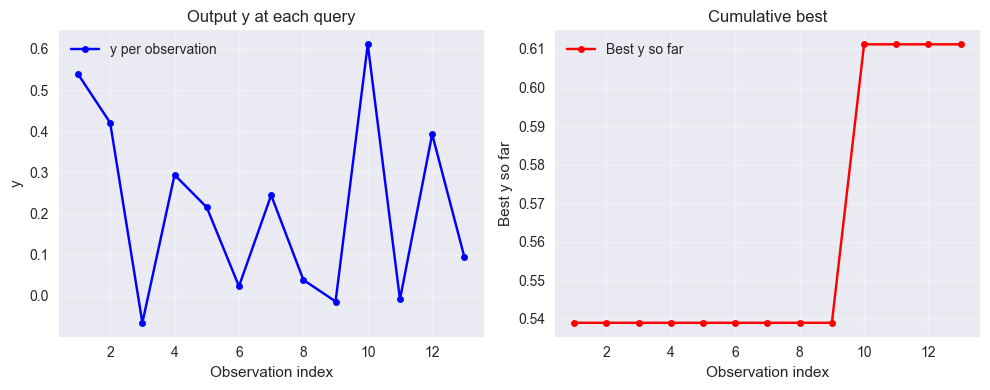

In [7]:
# Convergence: y per query (left) and running best (right)
n_obs = len(y)
obs_idx = np.arange(1, n_obs + 1, dtype=float)
best_so_far = np.maximum.accumulate(y)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
ax1.plot(obs_idx, y, 'o-', color='blue', markersize=5, label='y per observation')
ax1.set_xlabel('Observation index')
ax1.set_ylabel('y')
ax1.set_title('Output y at each query')
ax1.legend()
ax1.grid(True, alpha=0.3)

ax2.plot(obs_idx, best_so_far, 'o-', color='red', markersize=5, label='Best y so far')
ax2.set_xlabel('Observation index')
ax2.set_ylabel('Best y so far')
ax2.set_title('Cumulative best')
ax2.legend()
ax2.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


## 2. Visualize the points

`X` shape (n, 2): x_1 = `X[:, 0]`, x_2 = `X[:, 1]`. 2D: horizontal = x_1, vertical = x_2; 3D: floor = (x_1, x_2), height = y.

/Users/nikolaskarefyllidis/Desktop/60_ML-AI/10 main optimization/10 ICL BBO Challenge/black-box-optimization/src/utils/sampling_utils.py:63: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  x = sampler.random(n=n_sobol)[:n]


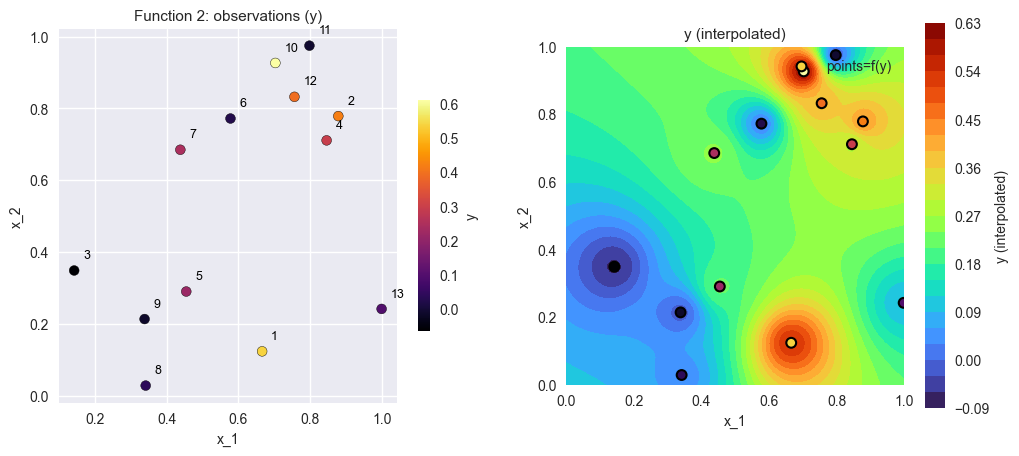

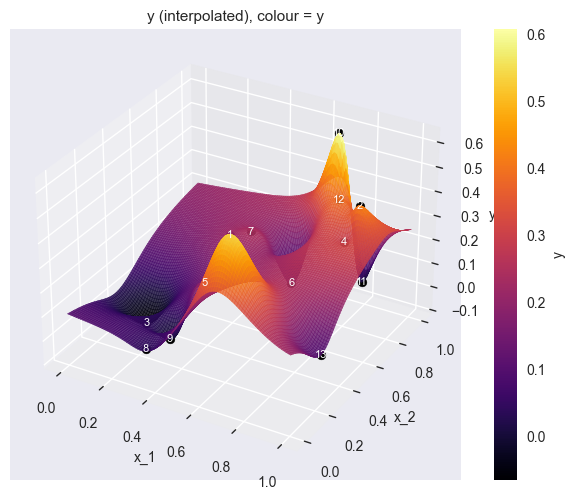

In [8]:
# ==== Evaluation grid ====
x1g = np.linspace(0, 1, n_grid)
x2g = np.linspace(0, 1, n_grid)
X1g, X2g = np.meshgrid(x1g, x2g)
grid_pts = np.column_stack([X1g.ravel(), X2g.ravel()])

# Candidate pool (same size as grid) for acquisition maximization
candidate_pts = sample_candidates(n_cand, 2, method=CANDIDATE_SAMPLING_METHOD, seed=42)

# Nearest-observation distance per grid point (L2)
diff = grid_pts[:, None, :] - X[None, :, :]           # (n_grid², n_obs, 2)
dists = np.sqrt((diff ** 2).sum(axis=2))
min_dist = np.min(dists, axis=1).reshape(X1g.shape)

# IDW interpolation of y onto the grid (used for the 3D surface)
dist_gx = np.sqrt(((grid_pts[:, None, :] - X[None, :, :]) ** 2).sum(axis=2)) + 1e-12
w = 1.0 / (dist_gx ** 2)
y_grid = (w * y[None, :]).sum(axis=1) / w.sum(axis=1)
Y_grid = y_grid.reshape(X1g.shape)

# ==== 2D plots: scatter (left) + interpolated contour (right) ====
fig = plt.figure(figsize=(12, 5))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

sc = ax1.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap="inferno", edgecolors="k")
plt.colorbar(sc, ax=ax1, shrink=0.6).set_label("y", fontsize=10)
for i in range(len(y)):
    ax1.text(X[i, 0] + 0.025, X[i, 1] + 0.025, str(i + 1), fontsize=9, color="black", ha="left", va="bottom", zorder=10)
ax1.set_xlabel("x_1", fontsize=10); ax1.set_ylabel("x_2", fontsize=10)
ax1.set_title("Function 2: observations (y)", fontsize=11); ax1.set_aspect("equal")

cf = ax2.contourf(X1g, X2g, Y_grid, levels=22, cmap="turbo")
plt.colorbar(cf, ax=ax2).set_label("y (interpolated)", fontsize=10)
ax2.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap="inferno", edgecolors="k", linewidths=1.5, zorder=2, label="points=f(y)")
ax2.set_xlabel("x_1", fontsize=10); ax2.set_ylabel("x_2", fontsize=10)
ax2.set_title("y (interpolated)", fontsize=11); ax2.set_aspect("equal")
ax2.legend(loc="upper right", fontsize=10)

# ==== 3D surface: colour = y (standalone figure) ====
norm_y = plt.Normalize(Y_grid.min(), Y_grid.max())
sm = cm.ScalarMappable(cmap=cm.inferno, norm=norm_y)
sm.set_array(Y_grid)

if IF_SHOW_PLOT or IF_EXPORT_PLOT:
    fig2 = plt.figure(figsize=(7, 5))
    ax3b = fig2.add_subplot(111, projection="3d")
    facecolors = cm.inferno(norm_y(Y_grid))[:-1, :-1]
    ax3b.plot_surface(X1g, X2g, Y_grid, facecolors=facecolors, rstride=1, cstride=1, shade=False, alpha=0.8)
    ax3b.scatter(X[:, 0], X[:, 1], y, c='black', s=40, edgecolors="k", depthshade=False)
    for i in range(len(y)):
        ax3b.text(X[i, 0], X[i, 1], y[i], str(i + 1), fontsize=8, color="white", ha="center", va="center")
    ax3b.set_xlabel("x_1", fontsize=10); ax3b.set_ylabel("x_2", fontsize=10); ax3b.set_zlabel("y", fontsize=10)
    ax3b.set_title("y (interpolated), colour = y", fontsize=11)
    plt.colorbar(sm, ax=ax3b).set_label("y", fontsize=10)

plt.tight_layout()
if IF_EXPORT_PLOT:
    out_dir = PLOT_EXPORT_DIR
    assert_not_under_initial_data(out_dir, project_root=repo_root)
    out_dir.mkdir(parents=True, exist_ok=True)
    out_path_2d = out_dir / "function_2_observations_and_distance_contour.png"
    fig.savefig(out_path_2d, dpi=150, format="png")
    print("Plot saved to", out_path_2d)
    out_path_3d = out_dir / "function_2_3d_surface_distance_colour.png"
    fig2.savefig(out_path_3d, dpi=150, format="png")
    print("Plot saved to", out_path_3d)
if IF_SHOW_PLOT:
    plt.show()


## 3. Suggest next point to submit, using Bayesian Optimization Methodology

### 3.1 Surrogate: GP kernels

We use three kernels: **RBF** (smooth), **Matérn (ν=1.5)** (rougher), **RBF + WhiteKernel** (adds observation noise). Each gives a different prior and uncertainty estimate.


In [9]:
# ==== Build and fit three GP kernels on (X, y) ====
# RBF: smooth isotropic  |  Matern: rougher  |  RBF+White: with explicit noise
kernel_RBF       = ConstantKernel(CONSTANT_KERNEL_SCALE) * RBF(length_scale=LENGTH_SCALE)
kernel_Matern    = ConstantKernel(CONSTANT_KERNEL_SCALE) * Matern(length_scale=LENGTH_SCALE, nu=MATERN_NU)
kernel_RBF_noise = ConstantKernel(CONSTANT_KERNEL_SCALE) * RBF(length_scale=LENGTH_SCALE) + WhiteKernel(noise_level=WHITE_NOISE_LEVEL)

gp_RBF       = GaussianProcessRegressor(kernel=kernel_RBF,       alpha=GP_ALPHA, n_restarts_optimizer=5, normalize_y=True)
gp_Matern    = GaussianProcessRegressor(kernel=kernel_Matern,    alpha=GP_ALPHA, n_restarts_optimizer=5, normalize_y=True)
gp_RBF_noise = GaussianProcessRegressor(kernel=kernel_RBF_noise, alpha=GP_ALPHA, n_restarts_optimizer=5, normalize_y=True)

gp_RBF.fit(X, y); gp_Matern.fit(X, y); gp_RBF_noise.fit(X, y)

# Posterior μ and σ on the visualization grid (reshaped for contour plots)
mu_gp_RBF,       sigma_gp_RBF       = gp_RBF.predict(grid_pts,        return_std=True)
mu_gp_Matern,    sigma_gp_Matern    = gp_Matern.predict(grid_pts,     return_std=True)
mu_gp_RBF_noise, sigma_gp_RBF_noise = gp_RBF_noise.predict(grid_pts,  return_std=True)
mu_gp_RBF,    sigma_gp_RBF    = mu_gp_RBF.reshape(X1g.shape),    sigma_gp_RBF.reshape(X1g.shape)
mu_gp_Matern, sigma_gp_Matern = mu_gp_Matern.reshape(X1g.shape), sigma_gp_Matern.reshape(X1g.shape)
mu_gp_RBF_noise, sigma_gp_RBF_noise = mu_gp_RBF_noise.reshape(X1g.shape), sigma_gp_RBF_noise.reshape(X1g.shape)

# Posterior on candidate_pts (for acquisition)
mu_cand_RBF,    sigma_cand_RBF    = gp_RBF.predict(candidate_pts,    return_std=True)
mu_cand_Matern, sigma_cand_Matern = gp_Matern.predict(candidate_pts, return_std=True)

# Aux GPs on −y: skopt acquisition assumes minimization, so argmax acq on −y ≡ argmax y
gp_neg_RBF, gp_neg_Matern = copy.deepcopy(gp_RBF), copy.deepcopy(gp_Matern)
gp_neg_RBF_noise = copy.deepcopy(gp_RBF_noise)
gp_neg_RBF.fit(X, -y); gp_neg_Matern.fit(X, -y); gp_neg_RBF_noise.fit(X, -y)

print(f"GP RBF kernel:    {gp_RBF.kernel_}")
print(f"GP Matern kernel: {gp_Matern.kernel_}")


GP RBF kernel:    1**2 * RBF(length_scale=0.014)
GP Matern kernel: 0.999**2 * Matern(length_scale=0.0398, nu=1.5)


/opt/homebrew/lib/python3.14/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


In [10]:
# ==== Kernel selection via log-marginal-likelihood (LML) ====
# Higher LML = better fit to the data under that kernel.
gps = [
    (gp_RBF,       gp_neg_RBF,    "RBF"),
    (gp_Matern,    gp_neg_Matern, "Matérn (ν=1.5)"),
    (gp_RBF_noise, gp_neg_RBF_noise, "RBF + WhiteKernel"),
]
lml_scores = {name: gp.log_marginal_likelihood_value_ for gp, _, name in gps}
best_name  = max(lml_scores, key=lml_scores.get)

print("Log-marginal-likelihood per kernel:")
for name, lml in lml_scores.items():
    marker = "  ← best" if name == best_name else ""
    print(f"  {name:<22}: {lml:.4f}{marker}")

# Set best_gp / best_gp_neg for use in downstream cells
best_gp     = next(gp  for gp, _, name in gps if name == best_name)
best_gp_neg = next(gn  for _,  gn, name in gps if name == best_name and gn is not None)
print(f"\nAuto-selected kernel: {best_name}")
print(f"  Fitted kernel: {best_gp.kernel_}")


Log-marginal-likelihood per kernel:
  RBF                   : -18.4462
  Matérn (ν=1.5)        : -18.4176
  RBF + WhiteKernel     : -18.3897  ← best

Auto-selected kernel: RBF + WhiteKernel
  Fitted kernel: 0.999**2 * RBF(length_scale=0.0465) + WhiteKernel(noise_level=1e-05)


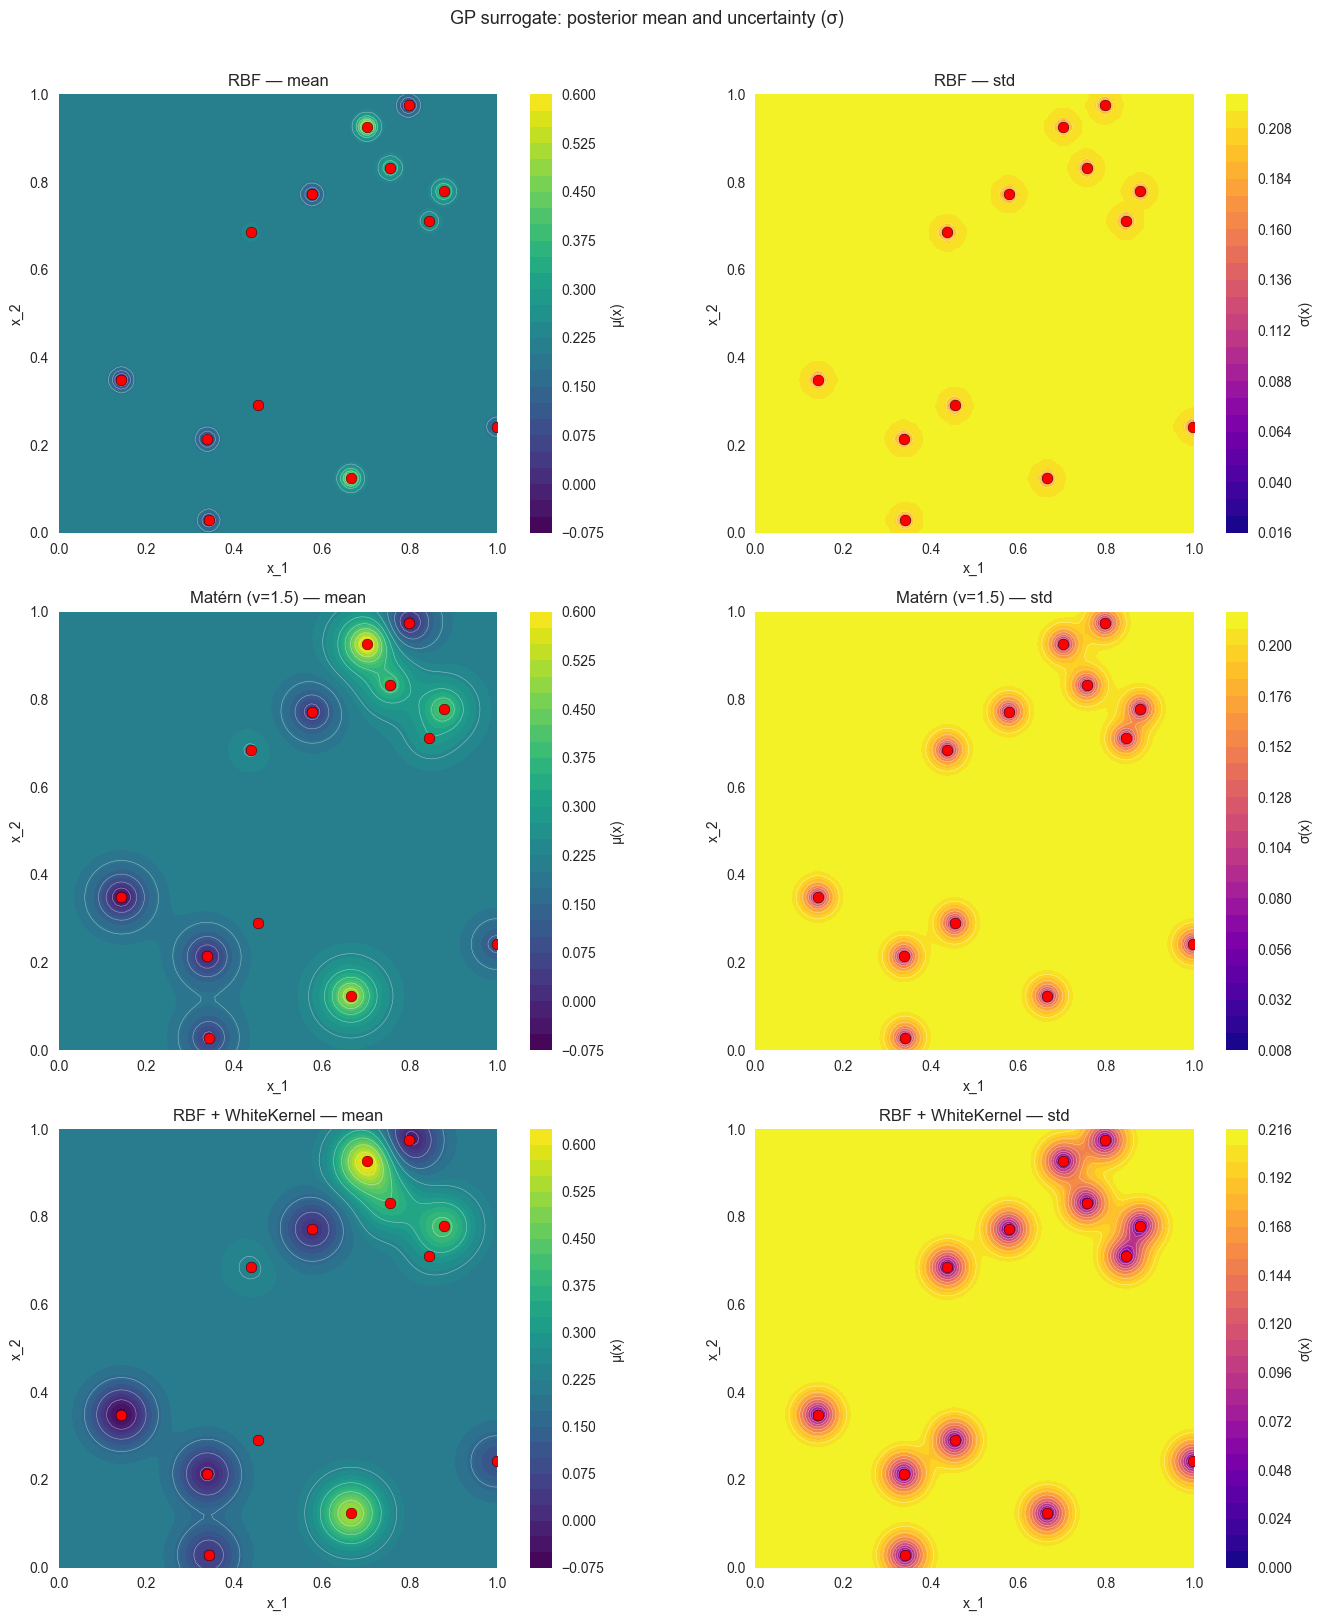

In [11]:
# GP posterior: mean (left) and std (right) for each kernel — shared colour scale per column
kernels_info = [
    (mu_gp_RBF,       sigma_gp_RBF,       "RBF"),
    (mu_gp_Matern,    sigma_gp_Matern,    "Matérn (ν=1.5)"),
    (mu_gp_RBF_noise, sigma_gp_RBF_noise, "RBF + WhiteKernel"),
]

fig, axes = plt.subplots(3, 2, figsize=(14, 16))
for i, (mu, sig, name) in enumerate(kernels_info):
    ax_mu, ax_sig = axes[i, 0], axes[i, 1]

    # Mean panel
    cf1 = ax_mu.contourf(X1g, X2g, mu, levels=30, cmap="viridis")
    ax_mu.contour(X1g, X2g, mu, levels=10, colors="white", linewidths=0.4, alpha=0.5)
    plt.colorbar(cf1, ax=ax_mu).set_label("μ(x)", fontsize=10)
    ax_mu.scatter(X[:, 0], X[:, 1], c="red", s=60, edgecolors="k", zorder=5)
    ax_mu.set_xlabel("x_1", fontsize=10); ax_mu.set_ylabel("x_2", fontsize=10)
    ax_mu.set_title(f"{name} — mean", fontsize=12)
    ax_mu.set_aspect("equal")

    # Std panel
    cf2 = ax_sig.contourf(X1g, X2g, sig, levels=30, cmap="plasma")
    ax_sig.contour(X1g, X2g, sig, levels=10, colors="white", linewidths=0.4, alpha=0.5)
    plt.colorbar(cf2, ax=ax_sig).set_label("σ(x)", fontsize=10)
    ax_sig.scatter(X[:, 0], X[:, 1], c="red", s=60, edgecolors="k", zorder=5)
    ax_sig.set_xlabel("x_1", fontsize=10); ax_sig.set_ylabel("x_2", fontsize=10)
    ax_sig.set_title(f"{name} — std", fontsize=12)
    ax_sig.set_aspect("equal")

plt.suptitle("GP surrogate: posterior mean and uncertainty (σ)", fontsize=13, y=1.01)
plt.tight_layout()
if IF_EXPORT_PLOT:
    out_dir = PLOT_EXPORT_DIR
    assert_not_under_initial_data(out_dir, project_root=repo_root)
    out_dir.mkdir(parents=True, exist_ok=True)
    out_path = out_dir / "function_2_gp_three_kernels.png"
    fig.savefig(out_path, dpi=150, format="png", bbox_inches="tight")
    print("Plot saved to", out_path)
if IF_SHOW_PLOT:
    plt.show()


### 3.2 Acquisition functions

EI (Expected Improvement), UCB (Upper Confidence Bound), PI (Probability of Improvement).


In [12]:
# ==== Acquisition functions (skopt, on −y GPs) ====
y_best = best_y

# EI: E[max(f(x) − f(x⁺), 0)]
EI_RBF    = gaussian_ei(candidate_pts, gp_neg_RBF,    y_opt=-y_best, xi=XI_EI_PI)
EI_Matern = gaussian_ei(candidate_pts, gp_neg_Matern, y_opt=-y_best, xi=XI_EI_PI)
x_best_EI_RBF    = candidate_pts[np.argmax(EI_RBF)]
x_best_EI_Matern = candidate_pts[np.argmax(EI_Matern)]

# PI: P(f(x) > f(x⁺) + ξ)
PI_RBF    = gaussian_pi(candidate_pts, gp_neg_RBF,    y_opt=-y_best, xi=XI_EI_PI)
PI_Matern = gaussian_pi(candidate_pts, gp_neg_Matern, y_opt=-y_best, xi=XI_EI_PI)
x_best_PI_RBF    = candidate_pts[np.argmax(PI_RBF)]
x_best_PI_Matern = candidate_pts[np.argmax(PI_Matern)]

# LCB: minimize μ(x) − κσ(x) on −y ≡ maximize UCB of y
LCB_RBF    = gaussian_lcb(candidate_pts, gp_neg_RBF,    kappa=KAPPA_UCB)
LCB_Matern = gaussian_lcb(candidate_pts, gp_neg_Matern, kappa=KAPPA_UCB)
x_best_UCB_RBF    = candidate_pts[np.argmin(LCB_RBF)]
x_best_UCB_Matern = candidate_pts[np.argmin(LCB_Matern)]

print(f"EI  (RBF):   next = ({x_best_EI_RBF[0]:.3f}, {x_best_EI_RBF[1]:.3f})")
print(f"PI  (RBF):   next = ({x_best_PI_RBF[0]:.3f}, {x_best_PI_RBF[1]:.3f})")
print(f"UCB (RBF):   next = ({x_best_UCB_RBF[0]:.3f}, {x_best_UCB_RBF[1]:.3f})")
print(f"Best y so far: {y_best:.4g}")


EI  (RBF):   next = (0.689, 0.928)
PI  (RBF):   next = (0.697, 0.935)
UCB (RBF):   next = (0.689, 0.914)
Best y so far: 0.6112


### 3.3 Acquisition function surfaces

EI and UCB heatmaps over the full grid — shows *where* each strategy wants to query, not just the argmax point.

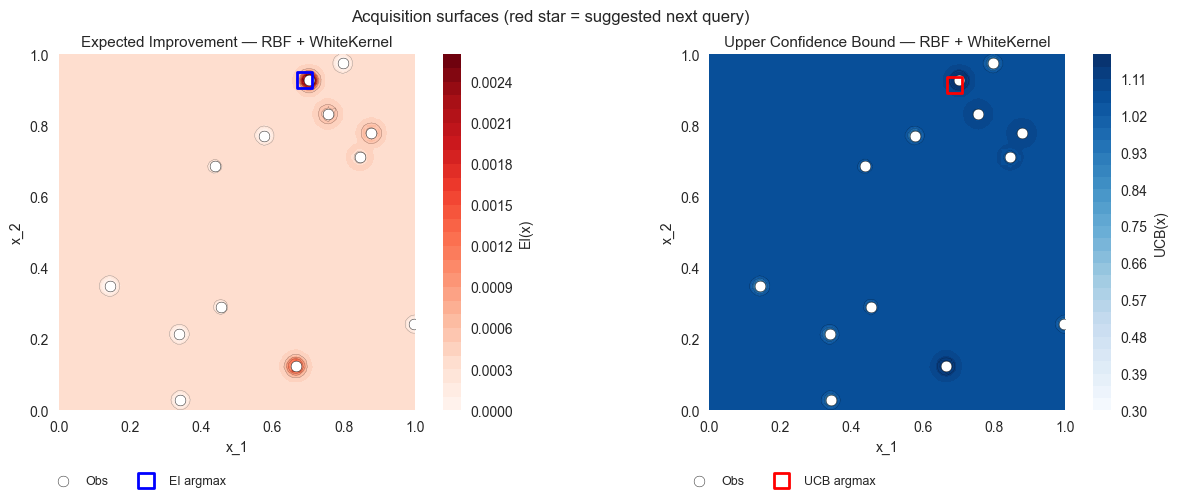

In [13]:
# ==== Acquisition surface plots (EI and LCB over the full grid) ====
# Predict on grid for best GP (auto-selected by LML above)
EI_grid  = gaussian_ei(grid_pts, best_gp_neg, y_opt=-y_best, xi=XI_EI_PI)
LCB_grid = gaussian_lcb(grid_pts, best_gp_neg, kappa=KAPPA_UCB)
UCB_grid = -LCB_grid   # UCB of y = −LCB of −y
EI_surf  = EI_grid.reshape(X1g.shape)
UCB_surf = UCB_grid.reshape(X1g.shape)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 5))

# EI surface
cf1 = ax1.contourf(X1g, X2g, EI_surf, levels=30, cmap="Reds")
ax1.contour(X1g, X2g, EI_surf, levels=10, colors="k", linewidths=0.3, alpha=0.4)
plt.colorbar(cf1, ax=ax1).set_label("EI(x)", fontsize=10)
ax1.scatter(X[:, 0], X[:, 1], c="white", s=60, edgecolors="k", zorder=5, label="Obs")
ax1.scatter(*x_best_EI_RBF, s=120, marker="s", c="none", edgecolors="blue", zorder=10, label="EI argmax", linewidths=2)
ax1.set_xlabel("x_1", fontsize=10); ax1.set_ylabel("x_2", fontsize=10)
ax1.set_title(f"Expected Improvement — {best_name}", fontsize=11)
ax1.legend(fontsize=9, ncol=2, bbox_to_anchor=(0.5, -0.15)); ax1.set_aspect("equal")

# UCB surface
cf2 = ax2.contourf(X1g, X2g, UCB_surf, levels=30, cmap="Blues")
ax2.contour(X1g, X2g, UCB_surf, levels=10, colors="k", linewidths=0.3, alpha=0.4)
plt.colorbar(cf2, ax=ax2).set_label("UCB(x)", fontsize=10)
ax2.scatter(X[:, 0], X[:, 1], c="white", s=60, edgecolors="k", zorder=5, label="Obs")
ax2.scatter(*x_best_UCB_RBF, s=120, marker="s", c="none", edgecolors="red", zorder=10, label="UCB argmax", linewidths=2)
ax2.set_xlabel("x_1", fontsize=10); ax2.set_ylabel("x_2", fontsize=10)
ax2.set_title(f"Upper Confidence Bound — {best_name}", fontsize=11)
ax2.legend(fontsize=9, ncol=2, bbox_to_anchor=(0.5, -0.15)); ax2.set_aspect("equal")

plt.suptitle("Acquisition surfaces (red star = suggested next query)", fontsize=12)
plt.tight_layout()
if IF_EXPORT_PLOT:
    out_dir = PLOT_EXPORT_DIR
    assert_not_under_initial_data(out_dir, project_root=repo_root)
    out_dir.mkdir(parents=True, exist_ok=True)
    fig.savefig(out_dir / "function_2_acquisition_surfaces.png", dpi=150, bbox_inches="tight")
    print("Saved acquisition surface plot")
if IF_SHOW_PLOT:
    plt.show()


In [14]:
# Warn if posterior uncertainty is near zero (EI/PI collapse to near-zero suggestions)
sigma_max = max(np.nanmax(sigma_gp_RBF), np.nanmax(sigma_gp_Matern))
if sigma_max < 1e-6:
    print(f"Low GP σ ({sigma_max:.2e}); EI/PI may be degenerate.")


In [15]:
# ==== Non-GP baseline suggestions (for comparison) ====
rng = np.random.default_rng(42)
best_x = best_x_so_far.copy()

# Exploit: small random step from current best
next_x_exploit = np.clip(best_x + rng.uniform(-0.1, 0.1, size=2), 0, 1)

# Explore: uniformly random point in [0, 1]²
next_x_explore = rng.uniform(0, 1, size=2)

# High-dist: candidate point farthest from any existing observation
min_dist_cand = np.min(np.sqrt(((candidate_pts[:, None, :] - X[None, :, :]) ** 2).sum(axis=2)), axis=1)
next_x_high_dist = np.clip(np.asarray(candidate_pts[np.argmax(min_dist_cand)]).ravel(), 0.0, 0.999999)

print("Exploit:  ", next_x_exploit)
print("Explore:  ", next_x_explore)
print("High-dist:", next_x_high_dist)


Exploit:   [0.75742777 0.91433989]
Explore:   [0.85859792 0.69736803]
High-dist: [0.00222255 0.99421912]


### Pairwise distances between suggestions (small = agree)

In [16]:
# Pairwise L2 distances between all suggested points (small = strategies agree)
names = ['EI', 'UCB', 'PI', 'High dist']
pts = [np.asarray(x).ravel() for x in [x_best_EI_RBF, x_best_UCB_RBF, x_best_PI_RBF, next_x_high_dist]]
n_pts = len(pts)
dists = np.zeros((n_pts, n_pts))
for i in range(n_pts):
    for j in range(n_pts):
        dists[i, j] = np.linalg.norm(pts[i] - pts[j])
for i in range(n_pts):
    for j in range(i + 1, n_pts):
        print(f"  {names[i]} vs {names[j]}: {dists[i, j]:.4f}")
max_d = dists.max()
if max_d < 0.15:
    print("\n>>> Suggestions agree (max pairwise dist < 0.15).")
else:
    print(f"\n>>> Suggestions differ (max dist = {max_d:.4f}); compare strategies.")


  EI vs UCB: 0.0139
  EI vs PI: 0.0108
  EI vs High dist: 0.6905
  UCB vs PI: 0.0230
  UCB vs High dist: 0.6915
  PI vs High dist: 0.6974

>>> Suggestions differ (max dist = 0.6974); compare strategies.


## 4. Select next query

In [17]:
# Choose the next query point — swap variable to change strategy:
#   x_best_EI_RBF / x_best_EI_Matern  — exploit + explore balance (recommended default)
#   x_best_UCB_RBF / x_best_UCB_Matern — broader exploration
#   x_best_PI_RBF  / x_best_PI_Matern  — greedy exploitation near best
#   next_x_high_dist                    — maximum gap from existing obs (pure explore)
#   next_x_exploit                      — small step from current best

# Use best kernel (auto-selected by LML); fall back to RBF if not available
EI_best = gaussian_ei(candidate_pts, best_gp_neg, y_opt=-y_best, xi=XI_EI_PI)
next_x  = candidate_pts[np.argmax(EI_best)]
next_x  = np.clip(np.asarray(next_x).ravel(), 0.0, 0.999999)

# Proximity check: warn if suggested point is too close to any existing observation
MIN_DIST_THRESHOLD = 0.05  # minimum acceptable L2 distance from any existing obs
dist_to_obs = np.sqrt(((X - next_x) ** 2).sum(axis=1))
nearest_idx  = np.argmin(dist_to_obs)
nearest_dist = dist_to_obs[nearest_idx]
if nearest_dist < MIN_DIST_THRESHOLD:
    print(f"⚠ WARNING: suggested point is only {nearest_dist:.4f} from obs #{nearest_idx+1} "
          f"at ({X[nearest_idx,0]:.4f}, {X[nearest_idx,1]:.4f}) — consider next_x_high_dist instead.")
    next_x = next_x_high_dist
    print(f"  Auto-switched to high-dist fallback: ({next_x[0]:.4f}, {next_x[1]:.4f})")

print(f"Next query | kernel: {best_name} | strategy: EI | xi={XI_EI_PI}")
print(f"  x = ({next_x[0]:.4f}, {next_x[1]:.4f})")
print(f"  Nearest existing obs: #{nearest_idx+1} at dist={nearest_dist:.4f}")
print(f"  Current best y = {best_y:.4g} at ({best_x_so_far[0]:.4f}, {best_x_so_far[1]:.4f})")


⚠ WARNING: suggested point is only 0.0123 from obs #10 at (0.7026, 0.9266) — consider next_x_high_dist instead.
  Auto-switched to high-dist fallback: (0.0022, 0.9942)
Next query | kernel: RBF + WhiteKernel | strategy: EI | xi=0.15
  x = (0.0022, 0.9942)
  Nearest existing obs: #10 at dist=0.0123
  Current best y = 0.6112 at (0.7026, 0.9266)


## 5. Illustrate the locations on the proposed query

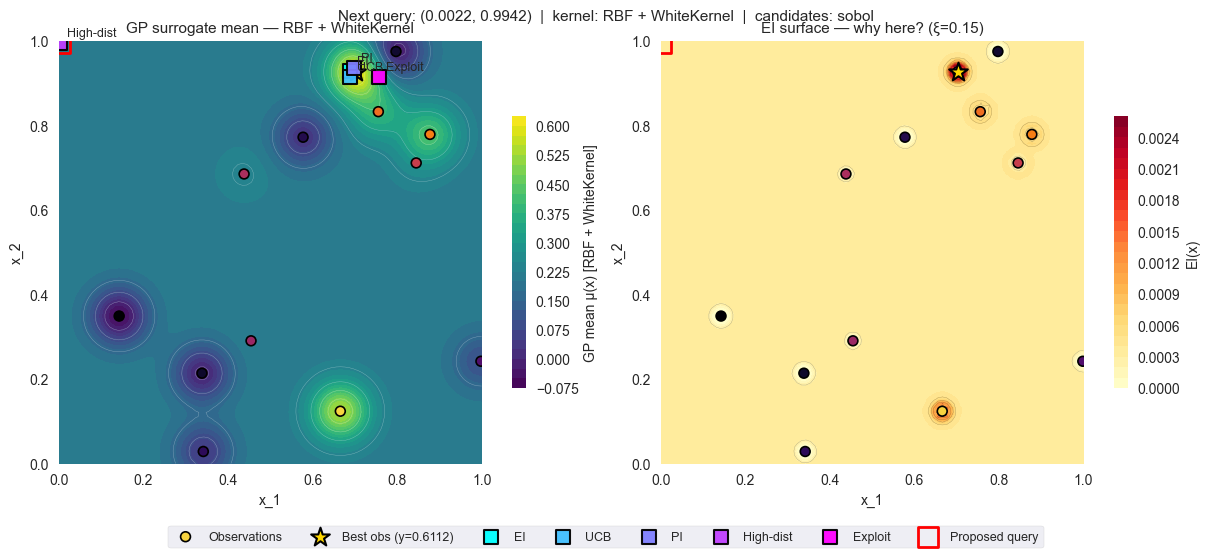

In [18]:
# ==== Summary plot: GP posterior mean (left) + EI surface (right) ====
# Background: best-kernel GP mean (not IDW) — directly reflects the surrogate model.
# Right panel shows WHY the acquisition suggested that point.

# next_x is set in Section 4 (Select next query); fallback below if that cell was skipped
try:
    _ = next_x
except NameError:
    _ei = gaussian_ei(candidate_pts, best_gp_neg, y_opt=-y_best, xi=XI_EI_PI)
    next_x = np.clip(np.asarray(candidate_pts[np.argmax(_ei)]).ravel(), 0.0, 0.999999)

_method = CANDIDATE_SAMPLING_METHOD

# Best-kernel mean on grid (already computed in GP fitting cell)
mu_best = (mu_gp_RBF if best_name == "RBF"
           else mu_gp_Matern if "Matern" in best_name
           else mu_gp_RBF_noise)

# Suggested points: same colour style as Function 3 (cool colormap, squares)
suggestions_pts = [x_best_EI_RBF, x_best_UCB_RBF, x_best_PI_RBF, next_x_high_dist, next_x_exploit]
suggestions_lbl = ["EI", "UCB", "PI", "High-dist", "Exploit"]
colors_combined = plt.cm.cool(np.linspace(0, 1, len(suggestions_pts)))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5), constrained_layout=True)

# ── Left: GP posterior mean ──────────────────────────────────────────────
cf1 = ax1.contourf(X1g, X2g, mu_best, levels=30, cmap="viridis")
ax1.contour(X1g, X2g, mu_best, levels=10, colors="white", linewidths=0.3, alpha=0.4)
plt.colorbar(cf1, ax=ax1, shrink=0.6).set_label(f"GP mean μ(x) [{best_name}]", fontsize=10)
ax1.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap="inferno", edgecolors="k",
            linewidths=1.2, zorder=5, label="Observations")
ax1.scatter(*best_x_so_far, s=200, marker="*", c="gold", edgecolors="k",
            linewidths=1.5, zorder=8, label=f"Best obs (y={best_y:.4g})")
for pt, lbl, col in zip(suggestions_pts, suggestions_lbl, colors_combined):
    ax1.scatter(pt[0], pt[1], s=100, marker='s', c=[col], edgecolors="k",
                linewidths=1.5, alpha=0.95, zorder=10, label=lbl)
    ax1.annotate(lbl, (pt[0], pt[1]), xytext=(5, 5), textcoords="offset points", fontsize=9, zorder=11)
# Proposed query: hollow red square (same as Function 3)
ax1.scatter(next_x[0], next_x[1], facecolors='none', s=200, marker='s', edgecolors='red',
            linewidths=2, zorder=12, label="Proposed query")
ax1.set_xlabel("x_1", fontsize=10); ax1.set_ylabel("x_2", fontsize=10)
ax1.set_title(f"GP surrogate mean — {best_name}", fontsize=11)
ax1.set_aspect("equal")

# ── Right: EI acquisition surface ────────────────────────────────────────
cf2 = ax2.contourf(X1g, X2g, EI_surf, levels=30, cmap="YlOrRd")
ax2.contour(X1g, X2g, EI_surf, levels=10, colors="k", linewidths=0.3, alpha=0.3)
plt.colorbar(cf2, ax=ax2, shrink=0.6).set_label("EI(x)", fontsize=10)
ax2.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap="inferno", edgecolors="k",
            linewidths=1.2, zorder=5, label="Observations")
ax2.scatter(*best_x_so_far, s=200, marker="*", c="gold", edgecolors="k",
            linewidths=1.5, zorder=8, label=f"Best obs")
ax2.scatter(next_x[0], next_x[1], facecolors='none', s=200, marker='s', edgecolors='red',
            linewidths=2, zorder=12, label="Proposed query")
ax2.set_xlabel("x_1", fontsize=10); ax2.set_ylabel("x_2", fontsize=10)
ax2.set_title(f"EI surface — why here? (ξ={XI_EI_PI})", fontsize=11)
ax2.set_aspect("equal")

# Shared legend below both panels
handles1, labels1 = ax1.get_legend_handles_labels()
fig.legend(handles1, labels1, loc="lower center", bbox_to_anchor=(0.5, -0.08),
           ncol=10, fontsize=9, frameon=True)
plt.suptitle(
    f"Next query: ({next_x[0]:.4f}, {next_x[1]:.4f})  |  "
    f"kernel: {best_name}  |  candidates: {_method}",
    fontsize=11, y=1.01
)
if IF_EXPORT_PLOT:
    out_dir = PLOT_EXPORT_DIR
    assert_not_under_initial_data(out_dir, project_root=repo_root)
    out_dir.mkdir(parents=True, exist_ok=True)
    fig.savefig(out_dir / "function_2_all_acquisition_points.png",
                dpi=150, format="png", bbox_inches="tight")
    print("Plot saved")
if IF_SHOW_PLOT:
    plt.show()


In [19]:
# Save next query: .npy for downstream code, .txt for the portal submission form
if IF_EXPORT_QUERIES:
    next_x_clip = np.clip(np.asarray(next_x, dtype=np.float64).ravel(), 0.0, 0.999999)
    portal_str = "-".join(f"{v:.6f}" for v in next_x_clip)
    out_dir = repo_root / "data" / "submissions" / "function_2"
    assert_not_under_initial_data(out_dir, project_root=repo_root)
    out_dir.mkdir(parents=True, exist_ok=True)
    np.save(out_dir / "next_input.npy", next_x_clip)
    (out_dir / "next_input_portal.txt").write_text(portal_str)
    print("Saved. Portal string:", portal_str)
else:
    print("IF_EXPORT_QUERIES=False; not saved.")


Saved. Portal string: 0.002223-0.994219
